In [1]:
import numpy.random as rnd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rnd.seed(42)

In [3]:
def simulate(X_0, N, gen_alpha, gen_sigma):
    alpha = np.array([
        gen_alpha(i) for i in range(N)
    ])
    sigma = np.array([
       gen_sigma(i) for i in range(N)
    ])
    X = np.zeros([N])
    X[0] = X_0

    for i in range(1,N):
        X[i] = X[i-1]*alpha[i] + rnd.randn(1)*sigma[i]

    return X


def plot_trajectory(X, caption=""):
    n = np.array(range(X.shape[0]))
    plt.plot(n, X)
    plt.xlabel("n")
    plt.ylabel("Xn")
    plt.title(caption)


def save_plot(name):
    plt.savefig(
        f'/home/olga/Projects/stochastiki/mc/plots3/{name}.jpg',
        dpi=800
    )

In [4]:
def get_hitting_time(X:np.array, c: float):
    assert c > 0, "wrong arg"

    return np.array((-c <= X) * (X <= c)).argmax()

### experiment 1: constants

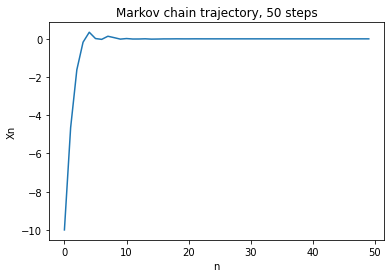

In [5]:
def get_alpha(n):
    return (n+1)**(-1)

def get_sigma(n):
    return np.sqrt(
        2**(-n)
    )


n_steps = 50
c = 1
X = simulate(
    N = n_steps,
    X_0 = -10,

    gen_alpha=get_alpha,
    gen_sigma=get_sigma
)
plot_trajectory(X, f"Markov chain trajectory, {n_steps} steps")
save_plot("e11")
t = get_hitting_time(X, c)

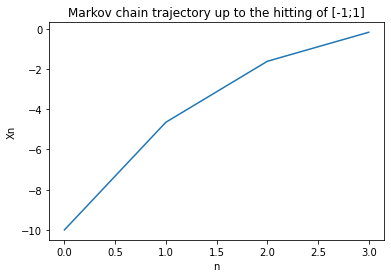

In [6]:
plot_trajectory(X[0:t+1], f"Markov chain trajectory up to the hitting of [-{c};{c}]")
save_plot("e12")

### experiment 2: random variances

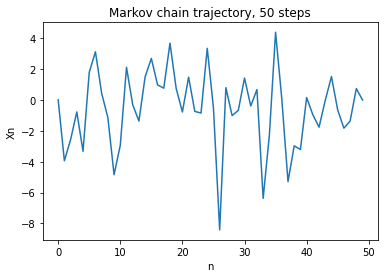

In [7]:
def get_alpha(n):
    return (n+1)**(-1)

def get_sigma(n):
    return np.sqrt(
        rnd.choice([5, 7, 10], size=[1])
    )

n_steps = 50
c = 1
X = simulate(
    N = n_steps,
    X_0 = 0,

    gen_alpha=get_alpha,
    gen_sigma=get_sigma
)
plot_trajectory(X, f"Markov chain trajectory, {n_steps} steps")
save_plot("e21")
t = get_hitting_time(X[1:], c)

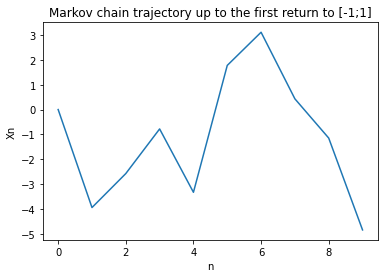

In [8]:
plot_trajectory(X[0:10], f"Markov chain trajectory up to the first return to [-{c};{c}]")
save_plot("e22")

### experiment 3: random coefficient

douc 2.1.7

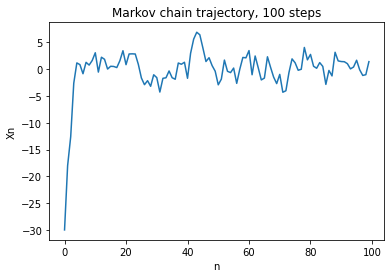

In [9]:
step = 10**(-1)

def get_alpha(n):
    return rnd.uniform(low=step, high=1-step, size=[1])

def get_sigma(n):
    return np.sqrt(
        2+n/(n+1)
    )

n_steps = 10**2
c = 1
X = simulate(
    N = n_steps,
    X_0 = -30,

    gen_alpha=get_alpha,
    gen_sigma=get_sigma
)
plot_trajectory(X, f"Markov chain trajectory, {n_steps} steps")
save_plot("e31")
t = get_hitting_time(X, c)

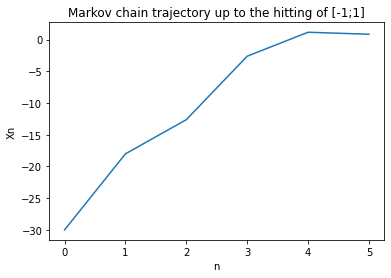

In [10]:
plot_trajectory(X[0:t+1], f"Markov chain trajectory up to the hitting of [-{c};{c}]")
save_plot("e32")

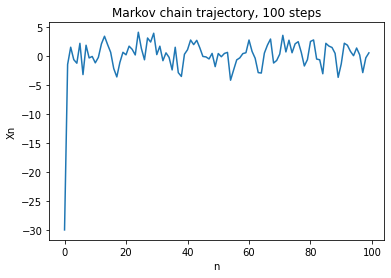

In [11]:
l = [1/k for k in range(1,15)]
# del l[-2]

def get_alpha(n):
    return rnd.choice(l)

def get_sigma(n):
    return np.sqrt(
        2+n/(n+1)
    )

n_steps = 10**2
c = 1
X = simulate(
    N = n_steps,
    X_0 = -30,

    gen_alpha=get_alpha,
    gen_sigma=get_sigma
)
plot_trajectory(X, f"Markov chain trajectory, {n_steps} steps")
save_plot("e31")
t = get_hitting_time(X, c)

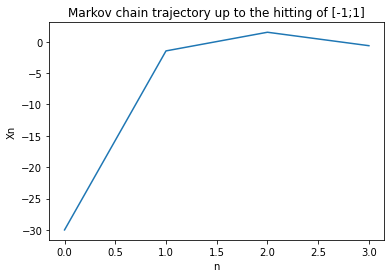

In [12]:
plot_trajectory(X[0:t+1], f"Markov chain trajectory up to the hitting of [-{c};{c}]")
save_plot("e32")

### Experiment 4. Pool of trajectories

In [13]:
def get_return_time(X:np.array, c: float, return_n: int = 1):
    assert c > 0, "wrong arg"

    return np.array((-c <= X[return_n:]) * (X[return_n:] <= c)).argmax()

def experiment(
        n_samples,
        gen_alpha,
        gen_sigma,
        x_0,
        c,
        max_steps,
        return_n: int = 1
):
    t = []
    for i in range(n_samples):
        X = simulate(
            N = max_steps,
            X_0 = x_0,

            gen_alpha=gen_alpha,
            gen_sigma=gen_sigma,
        )
        t.append(get_return_time(X, c, return_n=return_n))

    return t


In [14]:
def get_alpha(n):
    return (n+1)**(-2)

def get_sigma(n):
    return np.sqrt(
        rnd.choice([1/5, 1/7, 10], size=[1])
    )


t = experiment(
        10**4,
        get_alpha,
        get_sigma,
        x_0=0,
        c=1,
        max_steps=50
)

Text(0, 0.5, 'N observations')

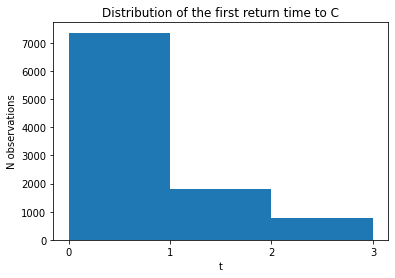

In [15]:
plt.hist(t
         , bins=range(4)
         )
plt.xticks(range(4))
plt.title("Distribution of the first return time to C")
plt.xlabel("t")
plt.ylabel("N observations")

### Experiment 5 - plot the corrollary

In [16]:
from typing import Callable, Iterable


def ind(x,c):
    return int(-c <= x <= c)


def em_generate(
        gen_alpha: Callable,
        gen_sigma: Callable,
        x_0: Iterable[float],
        n_samples: int = 10**4,
        c: float = 1,
        max_steps: int = 50,
        return_n: int = 1
):
    x = x_0
    t = []
    for x_i in x_0:
        t.append(experiment(
            n_samples,
            gen_alpha,
            gen_sigma,
            x_0=x_i,
            c=c,
            max_steps=max_steps,
            return_n = return_n
        ))

    return x,t


def em_calculate(
        x: Iterable[float],
        t: [[int]],
        eps: float,
        sigma: float,
        c: float = 1
):
    K = 4*sigma/np.sqrt(2*np.pi) + (3+eps)/2
    phi = 2 / (eps+1)

    x1 = []
    x2 = []
    for i, x_i in enumerate(list(x)):
        x1.append(np.average(
            list(map(
                lambda tau: phi**tau,
                t[i]
            ))
        ))
        x2.append(1 + np.abs(x_i) + K*ind(x_i,c)/2)

    return x1, x2


def em_viz(x1, x2):
    fig, ax = plt.subplots()
    ax.plot(x1, label="exp moment")
    ax.plot(x2, label="upper bound")
    ax.set_title("Demo of Corollary")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    fig.show()

In [17]:
step = 10**(-1)

def get_alpha(n):
    return rnd.uniform(low=step, high=1-step, size=[1])

def get_sigma(n):
    return np.sqrt(
        2+n/(n+1)
    )

In [18]:
x,t = em_generate(
    gen_alpha=get_alpha,
    gen_sigma=get_sigma,
    x_0=np.linspace(0.5,2.5,19),
    return_n = 0
)

In [19]:
x1, x2 = em_calculate(
    x,t,
    eps=0.9,
    sigma=3
)

In [20]:
max(x1)

1.1682120683858632

In [21]:
# em_viz(x1,x2)
# save_plot("e3e")

e53

/home/olga/Projects/CPI/venv/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


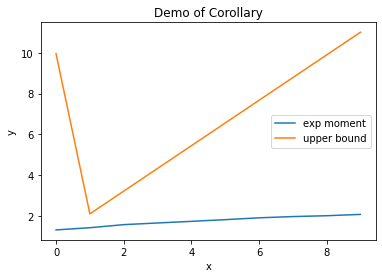

In [22]:
l = [3/4, 5/6, 8/9]
# del l[-2]

def get_alpha(n):
    return rnd.choice(l)

# def get_sigma(n):
#     return np.sqrt(
#         2+n/(n+1)
#     )
#
# def get_alpha(n):
#     return 3*(n+1)**(-1)

def get_sigma(n):
    return np.sqrt(
        rnd.choice([5, 1/5, 10], size=[1])
    )

x, t = em_generate(
    gen_alpha=get_alpha,
    gen_sigma=get_sigma,
    x_0=np.linspace(0, 10, 10)
)
x1, x2 = em_calculate(
    x, t,
    eps=8/9,
    sigma=10
)
em_viz(x1,x2)

///

In [23]:
# from scipy.stats import kstest

In [25]:
# kstest(t,"expon")

In [26]:
# !pip install distfit

In [27]:
# from distfit import distfit
#
# dist = distfit()
# dist.fit_transform(np.array(t))
# dist.plot()
# dist.plot_summary()

In [28]:
# kstest(t, 'expon')

### E3 a lot of trajectories

Text(0, 0.5, 'Xn')

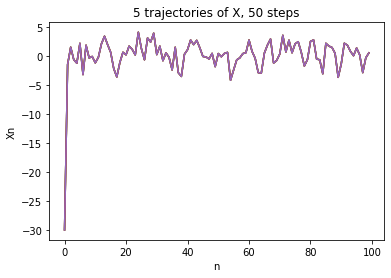

In [29]:
step = 10**(-1)
def get_alpha(n):
    return rnd.uniform(low=step, high=1-step, size=[1])

def get_sigma(n):
    return np.sqrt(
        2+n/(n+1)
    )

n_traj = 5
n_steps = 50
x = [
    simulate(
        X_0=-30,
        N=n_steps,
        gen_alpha=get_alpha,
        gen_sigma=get_sigma
    )
    for _ in range(n_traj)
]

# fig, ax = plt.subplots()
n = np.array(range(X.shape[0]))

for i in range(n_traj):
    # rnd.seed(i)
    plt.plot(X)

plt.title(f"{n_traj} trajectories of X, {n_steps} steps")
plt.xlabel("n")
plt.ylabel("Xn")

### e2 with the pool

In [30]:
def get_alpha(n):
    return (n+1)**(-1)

def get_sigma(n):
    return np.sqrt(
        rnd.choice([5, 7, 10], size=[1])
    )

In [31]:
def em_generate_2(
        gen_alpha: Callable,
        gen_sigma: Callable,
        x_0: Iterable[float],
        n_samples: int = 10**4,
        c: float = 1,
        max_steps: int = 50
):
    x = x_0
    t = []
    for x_i in x_0:
        t.append(experiment(
            n_samples,
            gen_alpha,
            gen_sigma,
            x_0=x_i,
            c=c,
            max_steps=max_steps,
            return_n = 1 if ind(x_i,c) else 0
        ))

    return x,t

/home/olga/Projects/CPI/venv/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


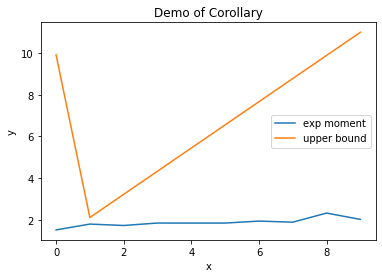

In [32]:
x, t = em_generate_2(
    gen_alpha=get_alpha,
    gen_sigma=get_sigma,
    x_0=np.linspace(0, 10, 10),
    n_samples=1000
)
x1, x2 = em_calculate(
    x, t,
    eps=3/4,
    sigma=10
)
em_viz(x1,x2)